In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
import numpy

In [73]:
BATCH_SIZE = 4

training_data_generator = ImageDataGenerator(rescale=1.0/255,

# Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.2, 

# Randomly rotate the image between -25,25 degrees
rotation_range=25, 

# Randomly shift the image along its width by up to +/- 5%
width_shift_range=0.1, 

# Randomly Shift the image along its height by up to +/- 5%
height_shift_range=0.1,

# Randomly flip the image horizontally
horizontal_flip=True

)

validation_data_generator = ImageDataGenerator(rescale=1.0/255)

In [74]:
training_iterator = training_data_generator.flow_from_directory('Covid19-dataset/train',class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)
print("\nLoading validation data...")
print(training_iterator.samples//BATCH_SIZE)

validation_iterator = validation_data_generator.flow_from_directory('Covid19-dataset/test',class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE, shuffle=False)

Found 251 images belonging to 3 classes.

Loading validation data...
62
Found 66 images belonging to 3 classes.


In [75]:
print("\nBuilding model...")

def design_model(training_data):
    model = Sequential()
    # add input layer
    model.add(keras.Input(shape=(256, 256, 1)))
    # maxpooling layers, convolutional layers and dropout layers
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    # extra layers
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu"))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.AUC()])
    # summarize model
    model.summary()
    return model


Building model...


In [76]:
# use model function
model = design_model(training_iterator)


Compiling model...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 84, 84, 5)      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 40, 40, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 18, 18, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │         2,919 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,271 (12.78 KB)

 Trainable params: 3,271 (12.78 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# early stopping implementation
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [79]:
print("\nTraining model...")
# fit the model early stopping
history = model.fit(
        training_iterator,
        steps_per_epoch=70, epochs=80, validation_data=validation_iterator,
        validation_steps=10,
        callbacks=[es])


Training model...
Epoch 1/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_6: 0.8288 - categorical_accuracy: 0.6810 - loss: 0.8138 - val_auc_6: 0.6861 - val_categorical_accuracy: 0.4500 - val_loss: 1.0240
Epoch 2/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc_6: 0.7976 - categorical_accuracy: 0.6163 - loss: 0.8240 - val_auc_6: 0.9686 - val_categorical_accuracy: 0.8462 - val_loss: 0.4868
Epoch 3/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc_6: 0.9091 - categorical_accuracy: 0.6889 - loss: 0.5653 - val_auc_6: 0.9136 - val_categorical_accuracy: 0.7750 - val_loss: 0.5788
Epoch 4/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc_6: 0.9238 - categorical_accuracy: 0.7667 - loss: 0.5239 - val_auc_6: 0.9656 - val_categorical_accuracy: 0.8462 - val_loss: 0.4212
Epoch 5/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc_6: 0.9193 - categorical_accuracy: 0.7939 - loss: 0.5333 - val_auc_6: 0.9289 - val_categorical_accuracy: 0.7750 - val_loss: 0.5327
Epoch 6/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

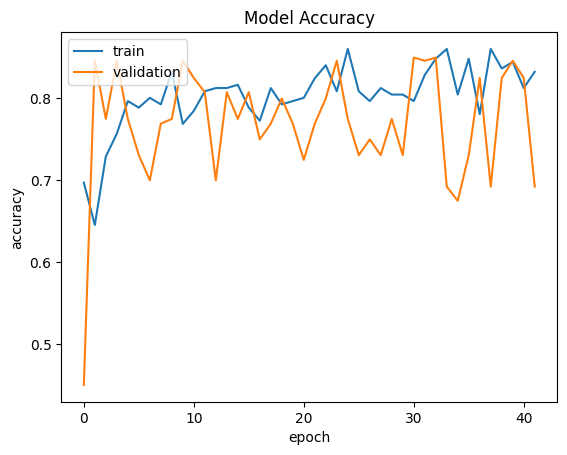

In [80]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

plt.show()

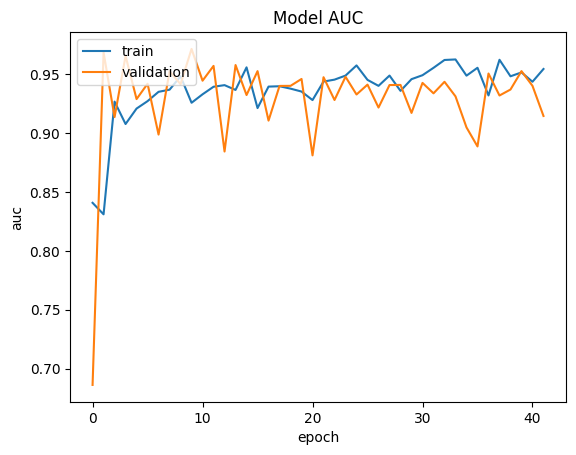

In [82]:
# plotting auc and validation auc over epochs
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(history.history['auc_6'])
ax2.plot(history.history['val_auc_6'])
ax2.set_title('Model AUC')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')


In [83]:
# Make predictions on trained model to assess its confusion matrix
predictions = model.predict(validation_iterator, steps=math.ceil(validation_iterator.samples/BATCH_SIZE))
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       Covid       1.00      0.77      0.87        26
      Normal       0.59      0.80      0.68        20
   Pneumonia       0.74      0.70      0.72        20

    accuracy                           0.76        66
   macro avg       0.78      0.76      0.76        66
weighted avg       0.80      0.76      0.77        66

[[20  5  1]
 [ 0 16  4]
 [ 0  6 14]]
